CEREAL PRODUCTION FORECASTING

The main objective is to develop a comprehensive platform for forecasting cereal production by region, using adapted machine learning models and ensuring wide accessibility of the data.
Our database contains variables on the production of 7 cereals for 13 regions in Burkina Faso from 1996 to 2022. For each region and each cereal type, there are productivity variables (yield, cultivated area, production which is the target variable) and climatic variables (rainfall, temperature, etc.).

We'll use all these variable to build models like Random Forest and XGBoost.

Performance metrics: We will use Root Mean Squared Error (RMSE) and the coefficient of determination.
We will choose the model that will give us 85% minimum precision on the coefficient of determination and the lowest RMSE.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
import os
from math import sqrt
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

1. Preprocessing

In [17]:
#Import the database
from google.colab import files
uploaded = files.upload()

Saving base_finale_céréales.xlsx to base_finale_céréales (1).xlsx


In [18]:
data = pd.read_excel('base_finale_céréales.xlsx')
data

,Région,Céréales,Année,Production (en tonnes),Superficie (en ha),Rendement (tonne/ha),Précipitations moyennes annuelles (en mm),Nombre de jours de pluie,Températures moyennes annuelles (en C°),Humidité relative maximale (en %),Vent moyen annuel (en m/s),Durée ensoleillement (en h/jr)
0,Boucle du Mouhoun,Arachide,1996,14810.0,37458.000000,0.395,676.0,66.0,29.30,63.0,2.300000,8.900000
1,Boucle du Mouhoun,Arachide,1997,22231.0,21702.000000,1.024,837.9,67.0,28.85,65.0,2.400000,8.700000
2,Boucle du Mouhoun,Arachide,1998,15490.0,30410.000000,0.509,945.3,75.0,29.20,65.0,2.400000,8.300000
3,Boucle du Mouhoun,Arachide,1999,17127.0,21862.000000,0.783,921.9,87.0,28.55,67.0,2.600000,8.800000
4,Boucle du Mouhoun,Arachide,2000,21565.0,26072.000000,0.827,580.7,68.0,29.15,65.0,2.700000,8.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
2452,Sud-Ouest,Sorgho,2018,79392.0,74126.000000,1.071,931.5,100.0,27.95,78.5,1.700000,7.700000
2453,Sud-Ouest,Sorgho,2019,100884.0,86576.000000,1.165,1234.7,94.0,28.25,78.0,1.600000,8.025000
2454,Sud-Ouest,Sorgho,2020,109016.0,86096.000000,1.266,1051.2,84.0,28.00,80.0,1.683333,7.866667
2455,Sud-Ouest,Sorgho,2021,117658.0,95165.855353,1.236,1273.3,95.0,28.20,83.0,1.600000,7.900000


In [19]:
#Structure of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Région                                     2457 non-null   object 
 1   Céréales                                   2457 non-null   object 
 2   Année                                      2457 non-null   int64  
 3   Production (en tonnes)                     2457 non-null   float64
 4   Superficie (en ha)                         2457 non-null   float64
 5   Rendement (tonne/ha)                       2457 non-null   object 
 6   Précipitations moyennes annuelles (en mm)  2457 non-null   float64
 7   Nombre de jours de pluie                   2457 non-null   float64
 8   Températures moyennes annuelles (en C°)    2457 non-null   float64
 9   Humidité relative maximale (en %)          2457 non-null   float64
 10  Vent moyen annuel (en m/

Our training data has +2400 observations. We will manage missing values.

In [20]:
data.isnull().sum()

,0
Région,0
Céréales,0
Année,0
Production (en tonnes),0
Superficie (en ha),0
Rendement (tonne/ha),0
Précipitations moyennes annuelles (en mm),0
Nombre de jours de pluie,0
Températures moyennes annuelles (en C°),0
Humidité relative maximale (en %),0


We do not have missing data.

Since our aim is to predict production, we're going to remove the yield variable to avoid data leakage. Indeed, calculating yield requires production and area values, so having yield in the model's dependent variables induces information leakage.

In [21]:
data = data.drop(columns=['Rendement (tonne/ha)'])

For the models, we need to pay attention with the spliting, because in data including time, the spliting must not be done randomly like we usually do with train_test_split of scikit-learn. It's beacuse in time series, we can't break the temporal structure (i.e the future should never be used to predict the past). Then in order to have control on spliting we use an index. Train data will be affected the first 80% of data and test data the last 20%.

2. Random Forest

In [22]:
# Define variables

target = "Production (en tonnes)"

categorical_features = ["Région", "Céréales"]
numeric_features = [ "Année", "Superficie (en ha)", "Températures moyennes annuelles (en C°)", "Précipitations moyennes annuelles (en mm)",
                    "Humidité relative maximale (en %)", "Vent moyen annuel (en m/s)", "Nombre de jours de pluie ", "Durée ensoleillement (en h/jr)"
]

X = data[categorical_features + numeric_features]
y = data[target]
groups = data["Région"]  # for GroupKFold

In [23]:
# Scaling numeric variables and encoding categorical variables

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [24]:
# Pipeline Random Forest

seed = 42
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(random_state=seed))
])

In [25]:
# Searching best hyperparameters

param_grid = {
    "model__n_estimators": [1, 5, 10, 50, 100, 200, 300],
    "model__max_depth": [None, 10, 20, 50],
    "model__min_samples_split": [2, 5]
}

from sklearn.model_selection import GroupKFold, GridSearchCV
group_kfold = GroupKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=group_kfold,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y, groups=groups)

print("Best hyperparameters :", grid_search.best_params_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best hyperparameters : {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 300}


In [26]:
#Model training
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

#Evaluation
print("R² Random Forest :", r2_score(y, y_pred))
print("RMSE Random Forest :", np.sqrt(mean_squared_error(y, y_pred)))

R² Random Forest : 0.9820696524348044
RMSE Random Forest : 9637.552539437747


In [27]:
# Features importance

# Retrieve column names after transformation
cat_names = best_model.named_steps["preprocessing"].named_transformers_["cat"].get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_names, numeric_features])

importances = best_model.named_steps["model"].feature_importances_

importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

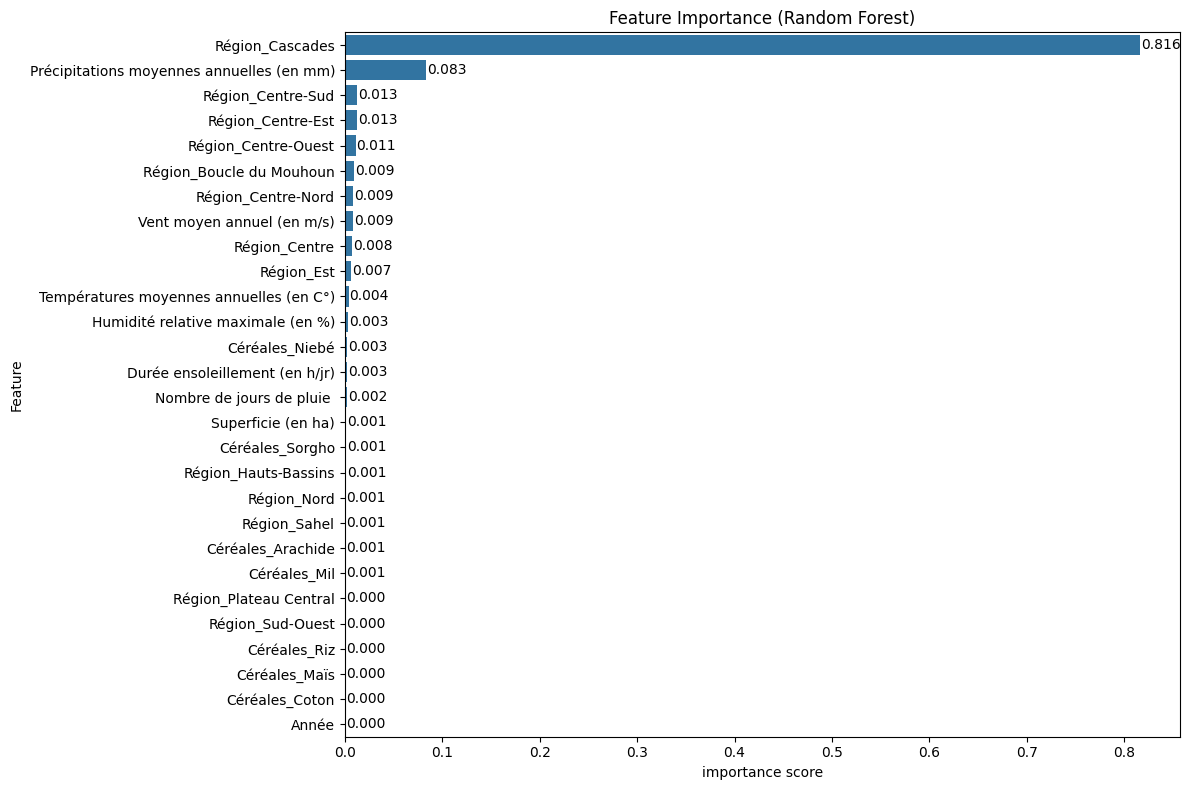

In [28]:
# Visualization of Features importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Importance", y="Feature", data=importances_df)

# Affichage des valeurs sur les barres
for i, (imp, feat) in enumerate(zip(importances_df["Importance"], importances_df["Feature"])):
    ax.text(imp + 0.001, i, f"{imp:.3f}", va='center', ha='left')

plt.title("Feature Importance (Random Forest)")
plt.xlabel("importance score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [30]:
# Prediction on new data
new_data = pd.DataFrame({
    'Région': ['Sahel'],
    'Céréales': ['Maïs'],
    'Année': [2023],
    'Superficie (en ha)': [5500],
    'Températures moyennes annuelles (en C°)': [30],
    'Précipitations moyennes annuelles (en mm)': [200],
    'Nombre de jours de pluie ': [7],
    'Humidité relative maximale (en %)': [65],
    'Vent moyen annuel (en m/s)': [22],
    'Durée ensoleillement (en h/jr)': [6]
})

prediction = best_model.predict(new_data)

print(f"Predicted Production : {prediction[0]:.2f} tons")

Predicted Production : 6323.16 tons


3. XGBoost

For this model, we need to pay attention with the spliting, because in data including time, the spliting must not be done randomly like we usually do with train_test_split of scikit-learn. It's beacuse in time series, we can't break the temporal structure (i.e the future should never be used to predict the past). Then in order to have control on spliting we use an index. Train data will be affected the first 80% of data and test data the last 20%.

In [45]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, stratify=groups, random_state=42
)

groups = data['Région']

In [35]:
# Pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

In [46]:
# Hyperparameter search grid
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.05, 0.1]
}

cv = GroupKFold(n_splits=5)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train, groups=groups_train)
print("Best hyperparameters :", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best hyperparameters : {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}


In [47]:
#Model training
xgb = grid_search.best_estimator_
y_pred = xgb.predict(X_test)

print("\n Évaluation :")
print("R² :", r2_score(y_test, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))



 Évaluation :
R² : 0.8201796709663582
RMSE : 32300.678703276146


In [50]:
#Importance of features
reg = xgb.named_steps['regressor']
ohe = xgb.named_steps['preprocessor'].named_transformers_['cat']
encoded_features = ohe.get_feature_names_out(categorical_features)
all_features = list(encoded_features) + numeric_features

importances = reg.feature_importances_
importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

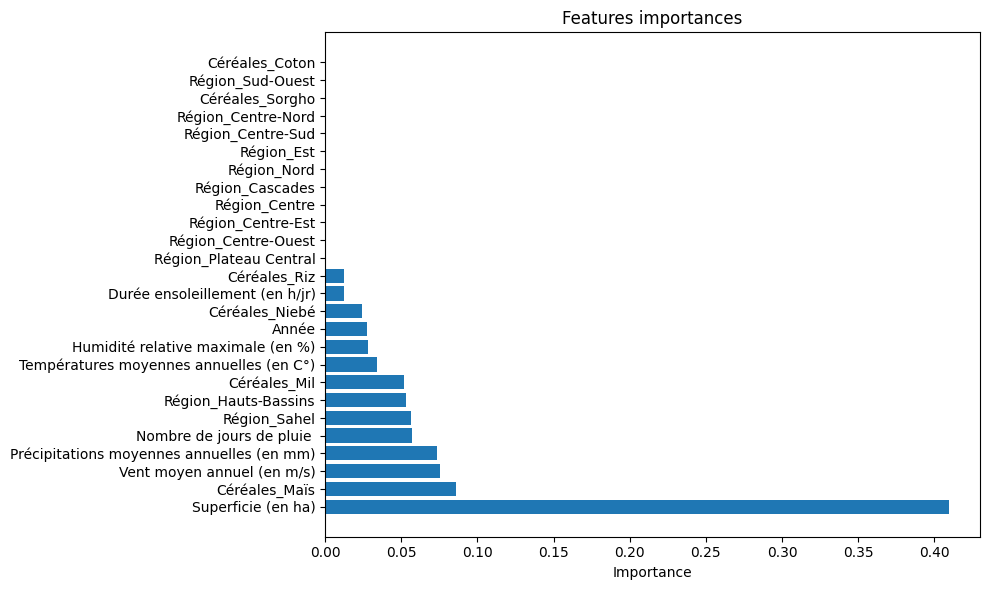

In [51]:
# 8. Displaying features importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Importance")
plt.title("Features importances")
plt.tight_layout()
plt.show()

In [53]:
#Prediction
predictionxgb = xgb.predict(new_data)

print(f"Predicted Production : {predictionxgb[0]:.2f} tons")

Predicted Production : 12755.49 tons


From the evaluation of each model, we can that Random Forest have a better determination coefficient (92%) and the lowest RMSE. Then it is the best model.